In [1]:
__author__ = "Yasaman Emami"
__email__ = ['emami.yasamann@gmail.com','yasaman.emami@sjsu.edu']

In [2]:
#import libraries

In [12]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Dropout, Dense, Flatten
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import random
import cv2
from skimage import transform
from tensorflow.keras.layers import Add, GlobalAveragePooling2D,\
	Dense, Flatten, Conv2D, Lambda,	Input, BatchNormalization, Activation, MaxPooling2D
import time
from keras import backend as K
import pandas as pd

## Load dataset

## CIFAR10

In [13]:
'''
source: https://keras.io/api/datasets/cifar10/
60k colored images 28X28
50k train
10k test
10 classes
Label	Description
0	    airplane
1	    automobile
2	    bird
3	    cat
4	    deer
5	    dog
6	    frog
7	    horse
8	    ship
9	    truck

'''

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [14]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [15]:
flat_y_train = list(np.concatenate(y_train).flat)

## Samples from dataset

In [7]:
def showSamples(train):
    class_names = { 0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
    #class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

    plt.figure(figsize=(15,15))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train[i])
        #plt.xlabel(y_train[i])
        plt.xlabel(class_names[flat_y_train[i]])
        ax.xaxis.label.set_color('green')
        plt.rc('font', size=16)
    plt.show()


## Build CNN Model

In [8]:

'''
source: https://www.tensorflow.org/tutorials/images/cnn

'''
def cnn(shap):
    model = models.Sequential()
    inputs = Input(shape=shap)
    x = Conv2D(32, 3, activation='relu', strides =1, padding = 'same')(inputs)
    # print(x.shape)
    x = BatchNormalization()(x)
    # print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    # print(x.shape)
    x = Conv2D(64, 3, activation='relu', strides =1, padding = 'same')(x)
    # print(x.shape)
    x = BatchNormalization()(x)
    # print(x.shape)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, 3, activation='relu', strides =1, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    # print("flat",x.shape)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    trainable_count = sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])

    model.summary()
    return model, trainable_count


## Build VGG Model

In [9]:
def vgg():
    base_model = tf.keras.applications.VGG19(
        include_top=False,
        pooling='avg',
        input_shape = (32,32,3),  
    )
    #base model freeze trainable parameters
    base_model.trainable = False
    # base_model.summary()
    return base_model

def myVggModel(base):
    model = models.Sequential()
    model.add(keras.Input(shape=(32,32,3)))
    #selecting layers before block4conv1
    for layer in base.layers[1:13]:
        model.add(layer)
    #add global avg pooling layer 
    model.add(base.layers[-1])
    model.add(keras.layers.Flatten())
    model.add(layers.Dense(10, activation=('softmax')))
    model.summary()
    # print("here",sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights]))
    trainable_count = sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
   
    return model, trainable_count

## Train model and plot evaluation metrics

In [11]:
def trainModel(x_train, y_train, x_test, y_test, model):
    # opt = keras.optimizers.Adam(learning_rate=0.09)
    # sgd = keras.optimizers.SGD(lr=0.001,momentum=.9,nesterov=False)
    batch_size = 32
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    history = model.fit(x_train, y_train, 
                        epochs=10, 
                        batch_size=batch_size, 
                        steps_per_epoch = x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test))
    
    return history

def plots(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.2, 1])
    plt.legend(loc='lower right')

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print("CNN model acc:", test_acc)
    return test_acc

##### Develop a CNN model with 5 convolutional layers (with kernel size= 3, stride =1, padding = “same”, activation function = “relu”) with following MaxPooling layer (Size= 2) and 3 fully connected layer (including one output layer). After each of the Convolutional layer apply Batch Normalization. In the fully connected layer apply dropout (rate 0.50)

## Q1--a

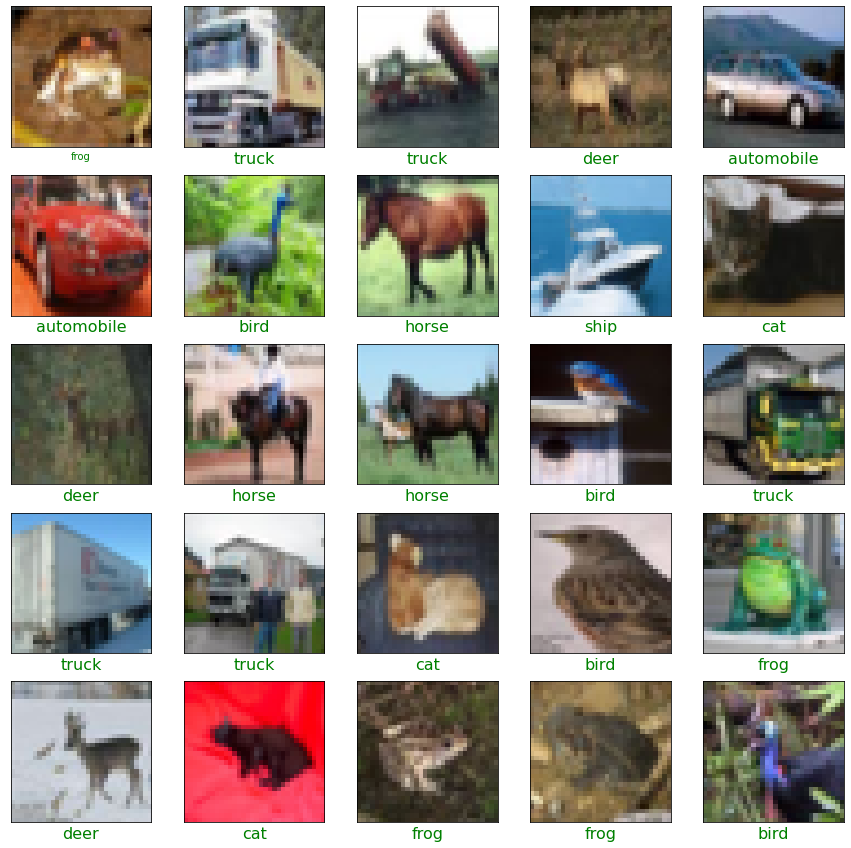

CNN Model from Scratch


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None,

2022-10-05 16:55:35.159573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


/usr/local/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1562/1562 [==============================] - 76s 48ms/step - loss: 1.7347 - accuracy: 0.3711 - val_loss: 1.3453 - val_accuracy: 0.5361
Epoch 2/10
1562/1562 [==============================] - 76s 49ms/step - loss: 1.2811 - accuracy: 0.5499 - val_loss: 1.2147 - val_accuracy: 0.5737
Epoch 3/10
1562/1562 [==============================] - 75s 48ms/step - loss: 1.0624 - accuracy: 0.6337 - val_loss: 0.9542 - val_accuracy: 0.6759
Epoch 4/10
1562/1562 [==============================] - 72s 46ms/step - loss: 0.9460 - accuracy: 0.6770 - val_loss: 0.9705 - val_accuracy: 0.6657
Epoch 5/10
1562/1562 [==============================] - 79s 51ms/step - loss: 0.8597 - accuracy: 0.7101 - val_loss: 0.9325 - val_accuracy: 0.6843
Epoch 6/10
1562/1562 [==============================] - 80s 51ms/step - loss: 0.7849 - accuracy: 0.7367 - val_loss: 0.8557 - val_accuracy: 0.7090
Epoch 7/10
1562/1562 [==============================] - 78s 50ms/step - loss: 0.7253 - accuracy: 0.7591 - val_loss: 0.8633 - val_accura

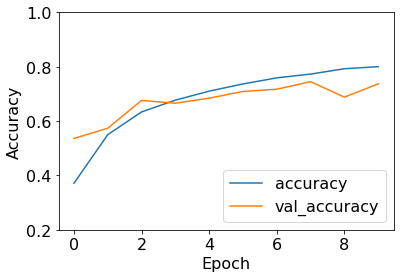

In [11]:
start = time.time()

showSamples(x_train)
print("CNN Model from Scratch\n","=================\n\n")
model, cnn_trainable_params = cnn((32,32,3))
history = trainModel(x_train, y_train, x_test, y_test, model)
cnn_acc = plots(history)

end = time.time()
cnn_time = end - start

##### Data Augmentation: Apply one image augmentation techniques on the Fashion Mnist train data to augment it and then apply the previously developed model on it

In [12]:
X_train = []
for image in x_train:
    #roate images between -70 & 70 degrees randomly
    X_train.append(transform.rotate(image, angle = random.randint(-70, 70)))
X_train = np.array(X_train)

In [13]:
#X_train.shape

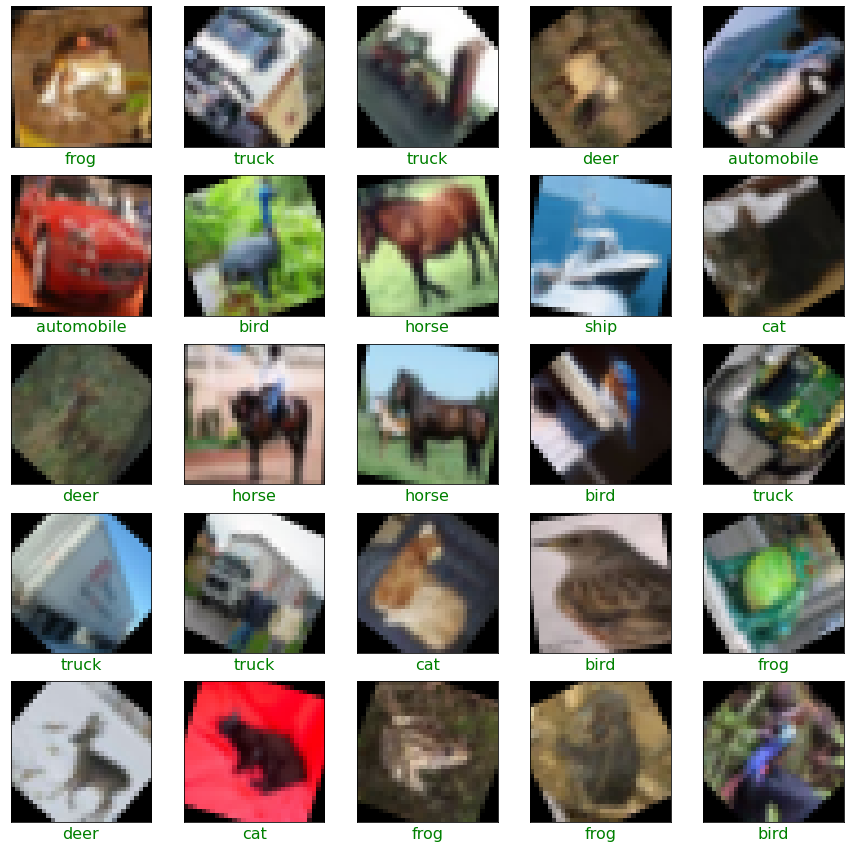

Data Augmentation -- CNN Model 


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_4 (B

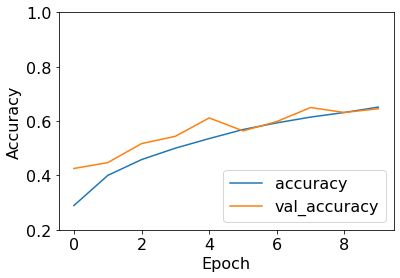

In [14]:
start = time.time()

showSamples(X_train)
print("Data Augmentation -- CNN Model \n","=================\n\n")
model, aug_trainable_params = cnn((32,32,3))
history = trainModel(X_train, y_train, x_test, y_test, model)
aug_acc = plots(history)

end = time.time()
aug_time = end - start

##### Transfer Learning: Load the VGG-19 model. Drop after the block4 conv1 layer (highlighted in the image below) and on top of it add one global average pooling and one final output layer. Keep the base model layers (VGG19) freeze

My VGG Architecture Model 


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)   

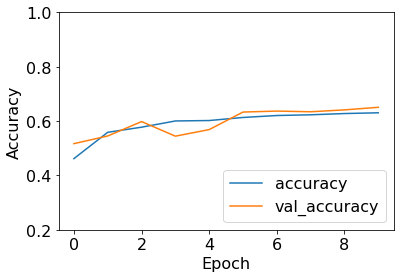

In [15]:
start = time.time()

base = vgg()
print("My VGG Architecture Model \n","=================\n\n")
model, vgg_trainable_params = myVggModel(base)
history = trainModel(x_train, y_train, x_test, y_test, model)
vgg_acc = plots(history)

end = time.time()
vgg_time = end - start

In [16]:
## Create comparison table

In [17]:
data = {'Models':  ['CNN Model', 'CNN + ImageAugmentation', 'VGG Architecture'],
        'Accuracy': [cnn_acc, aug_acc, vgg_acc],
        'Trainable params': [cnn_trainable_params, aug_trainable_params, vgg_trainable_params],
        'Execution Time': [cnn_time, aug_time, vgg_time],
        }

df = pd.DataFrame(data)

print (df)

                    Models  Accuracy  Trainable params  Execution Time
0                CNN Model    0.7368            648394      759.446044
1  CNN + ImageAugmentation    0.6456            648394      735.439495
2         VGG Architecture    0.6507              5130     1781.287828


# Q2 - shared Drive: https://drive.google.com/file/d/1QieO4b2Udrl2bKQIqwNl8a-KPCqbBcZy/view?usp=sharing


In [9]:
import joblib
#shared drive: https://drive.google.com/file/d/1QieO4b2Udrl2bKQIqwNl8a-KPCqbBcZy/view?usp=sharing"
model = joblib.load('/Users/yasamanemami/Downloads/finalized_model')

2022-10-05 20:35:40.298906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [22]:
target_test = tf.keras.utils.to_categorical(y_test, 10)
test_loss, test_acc = model.evaluate(x_test, target_test, verbose=2)
print("CNN model acc:", test_acc)

313/313 - 26s - loss: 2.1990 - accuracy: 0.6962 - 26s/epoch - 84ms/step
CNN model acc: 0.6962000131607056


## Q2 - Code:(XXXXXX Do not run on CPU, run on GPU XXXXXXXX)

In [23]:
import joblib 
import os
import numpy as np
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Add, GlobalAveragePooling2D,\
	Dense, Flatten, Conv2D, Lambda,	Input, BatchNormalization, Activation
from tensorflow.keras.optimizers import schedules, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import pandas as pd
from tensorflow.keras import datasets
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Dropout, Dense, Flatten
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import random
import cv2
from tensorflow.keras.layers import Add, GlobalAveragePooling2D,\
	Dense, Flatten, Conv2D, Lambda,	Input, BatchNormalization, Activation

In [ ]:
'''
source: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-resnet-from-scratch-with-tensorflow-2-and-keras.md
'''

#Load dataset 

(x_train, target_train), (x_test, target_test) = keras.datasets.cifar10.load_data()
initializer = tensorflow.keras.initializers.HeNormal()
loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)
boundaries = [32000, 48000]
values = [0.1, 0.01, 0.001]
lr_schedule = schedules.PiecewiseConstantDecay(boundaries, values)
optimizer_momentum = 0.9
optimizer = SGD(learning_rate=lr_schedule, momentum=optimizer_momentum)
y_train = tensorflow.keras.utils.to_categorical(target_train, 10)
y_test = tensorflow.keras.utils.to_categorical(target_test, 10)

In [ ]:
def residual_block(x, number_of_filters, match_filter_size=False):
	"""
		Residual block with
	"""
	

	# Create skip connection
	x_skip = x

	# Perform the original mapping
	if match_filter_size:
		x = Conv2D(number_of_filters, kernel_size=3, strides=2,\
			kernel_initializer=initializer, padding="same")(x_skip)
	else:
		x = Conv2D(number_of_filters, kernel_size=3, strides=1,\
			kernel_initializer=initializer, padding="same")(x_skip)
	x = BatchNormalization(axis=3)(x)
	x = Activation("relu")(x)
	x = Conv2D(number_of_filters, kernel_size=3,\
		kernel_initializer=initializer, padding="same")(x)
	x = BatchNormalization(axis=3)(x)

	# Perform matching of filter numbers if necessary
	if match_filter_size:
		x_skip = Lambda(lambda x: tensorflow.pad(x[:, ::2, ::2, :], tensorflow.constant([[0, 0,], [0, 0], [0, 0], [number_of_filters//4, number_of_filters//4]]), mode="CONSTANT"))(x_skip)
	

	# Add the skip connection to the regular mapping
	x = Add()([x, x_skip])

	# Nonlinearly activate the result
	x = Activation("relu")(x)

	# Return the result
	return x


def ResidualBlocks(x):
	"""
		Set up the residual blocks.
	"""
	
	# Set initial filter size
	filter_size = 32

	# Paper: "Then we use a stack of 6n layers (...)
	#	with 2n layers for each feature map size."
	# 6n/2n = 3, so there are always 3 groups.
	for layer_group in range(3):

		# Each block in our code has 2 weighted layers,
		# and each group has 2n such blocks,
		# so 2n/2 = n blocks per group.
		for block in range(3):

			# Perform filter size increase at every
			# first layer in the 2nd block onwards.
			# Apply Conv block for projecting the skip
			# connection.
			if layer_group > 0 and block == 0:
				filter_size *= 2
				x = residual_block(x, filter_size, match_filter_size=True)
			else:
				x = residual_block(x, filter_size)

	# Return final layer
	return x


In [ ]:
def my_model():
	"""
		Base structure of the model, with residual blocks
		attached.
	"""
	# Define model structure
	# logits are returned because Softmax is pushed to loss function.
	inputs = Input(shape=(32,32,3))
	x = Conv2D(kernel_size=3,\
		strides=1, filters=32, kernel_initializer=initializer, padding="same")(inputs)
	x = BatchNormalization()(x)
	x = Activation("relu")(x)
	x = ResidualBlocks(x)
	x = GlobalAveragePooling2D()(x)
	x = Flatten()(x)
	outputs = Dense(10, activation='softmax')(x)
	model = Model(inputs=inputs, outputs=outputs)
	model.compile(loss=loss,\
				  optimizer=optimizer,\
				  	metrics=['accuracy'])

	# Print model summary
	model.summary()
	return model

def train_model(model):
	"""
		Train an initialized model.
	"""

	# Fit data to model
	history = model.fit(x_train, y_train, 
                        epochs=10, 
                        batch_size=32, 
                        steps_per_epoch = x_train.shape[0]//32,
                        validation_data=(x_test, y_test))
	model.save('my_model') 
	joblib.dump(model, 'finalized_model')
    
	return model, history


def evaluate_model(model, history):
	"""
		Evaluate a trained model.
	"""
	
	plt.plot(history.history['accuracy'], label='accuracy')
	plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy')
	plt.ylim([0.5, 1])
	plt.legend(loc='lower right')
	test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
	print("Test accuracy:", test_acc)

	
print(y_test.shape)
# Initialize ResNet
resnet = my_model()

# Train ResNet model
trained_resnet, history = train_model(resnet)

# Evalute trained ResNet model post training
evaluate_model(trained_resnet,history)